In [10]:
%%writefile Ind_Turn_Amihud_Pvc_2023.py

import sys
import os 
module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path: 
    sys.path.append(module_path)


import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tools.Sample_Tools as smpl

from base.JuUnits import excute_for_multidates

from sklearn import linear_model



def get_cur_ret(stock_df):
    cur_ret = smpl.get_current_return(stock_df,'close')
    cur_ret.name = 'ret'
    return cur_ret

def get_turn_cv(stock_df):
    turnover = stock_df['volume'] / (stock_df['lshares'] *100) # 手/万股
    # # # 换手率稳定性=𝑠𝑡𝑑(最近一段时间日度换手率序列) #不太行
    turn_std_1m = excute_for_multidates(turnover, lambda x:x.rolling(22).std(), level=1)
    # turn_std_3m = excute_for_multidates(turnover, lambda x:x.rolling(66).std(), level=1)

    # # 换手率变异系数=𝑠𝑡𝑑(最近一段时间日度换手率序列)/𝑚𝑒𝑎𝑛(最近一段时间日度换手率序列)
    turn_mean_1m = excute_for_multidates(turnover, lambda x:x.rolling(22).mean(), level=1)
    # turn_mean_3m = excute_for_multidates(turnover, lambda x:x.rolling(66).mean(), level=1)
    
    turn_cv_1m = turn_std_1m/turn_mean_1m # 好
    # turn_cv_3m = turn_std_3m/turn_mean_3m 
    turn_cv_1m.name = 'turn_cv'
    return turn_cv_1m

# # 异常换手率=(𝑚𝑒𝑎𝑛(短期日度换手率)−𝑚𝑒𝑎𝑛(长期日度换手率)) /𝑠𝑡𝑑(长期日度换手率) #不太行
# turn_ext = (turn_std_1m - turn_std_3m)/turn_std_3m

def get_amihud(stock_df, cur_ret):
    cur_ret_abs = cur_ret.abs()
    # 非流动性=𝑚𝑒𝑎𝑛(日绝对收益率/日成交额) # 好 #不要平均，平均后不管是信号还是收益还是ic，都显著下降，
    amihud = cur_ret_abs / stock_df['amount']
    amihud.name = 'amihud'
    return amihud

def get_amihud_adv(stock_df, cur_ret):
    cur_ret_abs = cur_ret.abs()
    # 非流动性_改进=𝑚𝑒𝑎𝑛(最近一段时间日绝对收益率序列)/𝑚𝑒𝑎𝑛(最近一段时间日成交额序列) # 好
    amihud_adv_5 = excute_for_multidates(cur_ret_abs, lambda x:x.rolling(5).mean(), level=1) / excute_for_multidates(stock_df['amount'], lambda x:x.rolling(5).mean(), level=1) 
    amihud_adv_5.name = 'amihud_adv'
    return amihud_adv_5

def get_amihud_negative(stock_df):
# 负收益非流动性=𝑚𝑒𝑎𝑛(最近一段时间日绝对收益率序列_收益为负)/𝑚𝑒𝑎𝑛(最近一段时间日成交额序列_收益为负) # 一般，凹型，窗口越大信号越明显，但是总收益再下降。
    negative_ret = smpl.get_current_return(stock_df,'close')
    negative_ret[negative_ret>0]=0
    negative_ret = negative_ret.abs()
    amihud_negative_22 = excute_for_multidates(negative_ret, lambda x:x.rolling(22).mean(), level=1) / excute_for_multidates(stock_df['amount']*np.sign(negative_ret), lambda x:x.rolling(22).mean(), level=1) 
    amihud_negative_22.name = 'amihud_negative'
    return amihud_negative_22

def get_amihud_cv(stock_df, cur_ret):
    cur_ret_abs = cur_ret.abs()
    # 非流动性变异系数 = (𝑠𝑡𝑑(绝对收益率序列)/𝑚𝑒𝑎𝑛(绝对收益率序列)) / (𝑠𝑡𝑑(成交额序列)/𝑚𝑒𝑎𝑛(成交额序列)) # 一般，信号不是非常显著，ic还行，高低差异大，中间没啥差异且跟第一差别不算大。
    numerator = excute_for_multidates(cur_ret_abs, lambda x:x.rolling(5).std(), level=1) / excute_for_multidates(cur_ret_abs, lambda x:x.rolling(5).𝑚𝑒𝑎𝑛(), level=1)
    denominator = excute_for_multidates(stock_df['amount'], lambda x:x.rolling(5).std(), level=1) / excute_for_multidates(stock_df['amount'], lambda x:x.rolling(5).𝑚𝑒𝑎𝑛(), level=1)
    amihud_cv_5 = numerator / denominator
    amihud_cv_5.name = 'amihud_cv'
    return amihud_cv_5


def get_obv(stock_df, cur_ret):
    # 𝑂𝐵𝑉 = 𝑠𝑢𝑚(𝑣𝑜𝑙𝑢𝑚𝑒); 
    # 𝑣𝑜𝑙𝑢𝑚𝑒 = {
    #           𝑣𝑜𝑙𝑢𝑚𝑒   𝑐𝑙𝑜𝑠𝑒>𝑐𝑙𝑜𝑠𝑒[1]
    #           −𝑣𝑜𝑙𝑢𝑚𝑒  𝑐𝑙𝑜𝑠𝑒<𝑐𝑙𝑜𝑠𝑒[1]
    #           0        𝑐𝑙𝑜𝑠𝑒=𝑐𝑙𝑜𝑠𝑒[1]
    #          }
    obv = cur_ret * stock_df['volume'] 
    obv.name = 'obv'
    return obv

def get_pvc(stock_df):
    # 量价相关性 = corr(close,volume) ##  好（10天），注意，慢（约14m）
    # pvc_5 = excute_for_multidates(stock_df, lambda x:x['close'].rolling(5).apply(lambda xx:xx.corr(x.loc[xx.index]['volume'])),level=1)
    pvc_10 = excute_for_multidates(stock_df, lambda x:x['close'].rolling(10).apply(lambda xx:xx.corr(x.loc[xx.index]['volume'])),level=1)
    # pvc_22 = excute_for_multidates(stock_df, lambda x:x['close'].rolling(22).apply(lambda xx:xx.corr(x.loc[xx.index]['volume'])),level=1)
    pvc_10.name = 'pvc'
    return pvc_10

def get_pvc_optimize(stock_df,cur_ret,pvc):
    # 量价相关性_改进因子 是量价相关性因子剔除对应期限的涨跌幅和成交量，剔除后的信息能更加纯粹体现量价相关程度。该因子的方向为负。
    # 量价相关性_改进 = 量价相关性 − 𝛽1∗𝑅𝑒𝑡 − 𝛽2∗𝑉𝑜𝑙 − 𝜀 (与pvc相反，效果和质量差不多，但ic较差)
    pvc.name = 'pvc'
    def reg(df):
        X = df[['ret','volume']].values.reshape(-1, 2)

        model = linear_model.LinearRegression(fit_intercept=True, n_jobs=1)
        res = model.fit(X,df[['pvc']].values.reshape(-1, 1))

        predict = model.predict(X)
        resid = df['pvc'] - predict.flatten()
        return resid
    pvc_df = pd.concat([pvc, cur_ret, stock_df['volume']],axis=1).dropna()
    pvc_optimize = excute_for_multidates(pvc_df, lambda x:reg(x),level=1)
    pvc_optimize.name = 'pvc_optimize'
    return pvc_optimize



Overwriting Ind_New_Tech_2023.py


In [4]:
# from tools.Cacher import (CACHE_TYPE, save_cache,load_cache_adv,load_cache)

# tail = False
# if tail:
#     df_all = load_cache('all_tail_qfq',cache_type=CACHE_TYPE.STOCK).sort_index()
# else:
#     df_all = load_cache('all_train_qfq',cache_type=CACHE_TYPE.STOCK).sort_index()
# smpl.optimize_data_type(df_all)

# df_treated = pretreate_data(df_all)

# year = '2020'
# data_ = df_all.loc[year+'-01-03':year+'-12-28']


# ret = smpl.get_forward_return(data_,'close')
# ret.name = 'ret_forward'
# ret[np.abs(ret)>0.15]=np.nan

In [410]:
# import numpy as np
# import matplotlib.pyplot as plt
import pandas as pd

# a = (np.random.rand(10)+0.5)*100
# # np.random.shuffle(a)
# print(a)
# plt.bar(range(1,11),a)
# plt.show()
# # (a[0]-a[-1])/(a[1]-a[-2])
# print(  ((a[0]-a[-1]) + (a[1]-a[-2]))/((a[2]-a[-3])+(a[3]-a[-4])) +1e-06)
# a= a[::-1]
# print(  ((a[0]-a[-1])*0.7 + (a[1]-a[-2])*0.3)/((a[2]-a[-3])*0.3+(a[3]-a[-4])*0.7) +1e-06)

# y = np.random.rand(10).argsort() +1
# # y = np.array([5,4,3,2,1])
# np.random.shuffle(y)
# x = np.arange(1,11)
# print(y)
# plt.bar(x,y)
# plt.show()


# print((y[0]-y[-1])/(y[1]-y[-2]))
# print(  ((y[0]-y[-1]) + (y[1]-y[-2]) )/((y[2]-y[-3]) +(y[3]-y[-4]) ) +1e-06)
# print(  ((y[0]-y[-1])*0.7 + (y[1]-y[-2])*0.3)/((y[2]-y[-3])*0.3+(y[3]-y[-4])*0.7) +1e-06)
# print(np.linalg.lstsq(np.vstack([x,np.ones(len(x))]).T, y.reshape(-1,1),rcond=None)[0][0])



'green'

In [16]:
# p = pvc_5.loc[(slice(None),['000001','000002','000006'])]
# p.name = 'pvc'
# ret_a = cur_ret.loc[(slice(None),['000001','000002','000006'])]
# a = data_replenish['volume'].loc[(slice(None),['000001','000002','000006'])]

# tmp = pd.concat([p,ret_a,a],axis=1).dropna()


# 1）IC值的均值
# （2）IC值的标准差
# （3）IC大于0的比例
# （4）IC绝对值大于0.02的比例
# （5）IR （IR = IC均值/IC标准差）

# Monotony Score  = lstsq.abs > 0.5


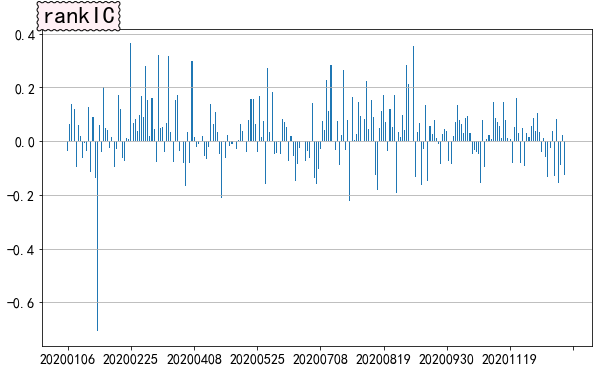

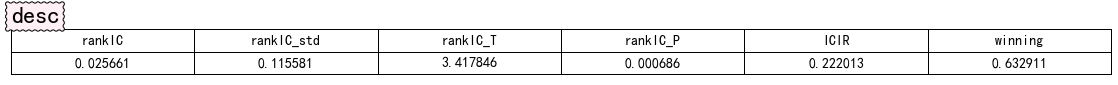

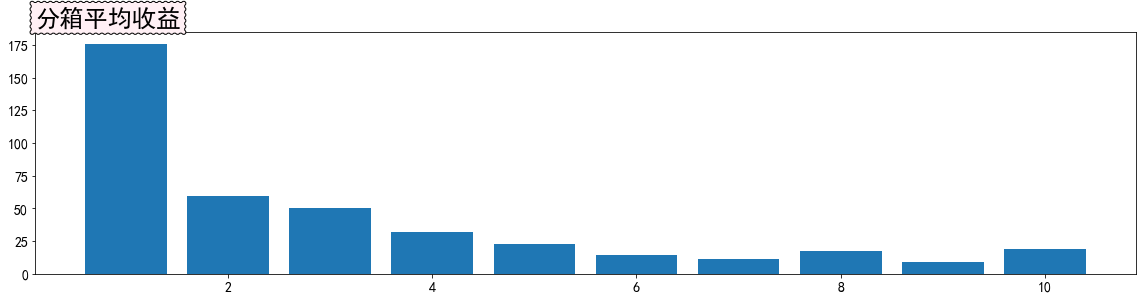

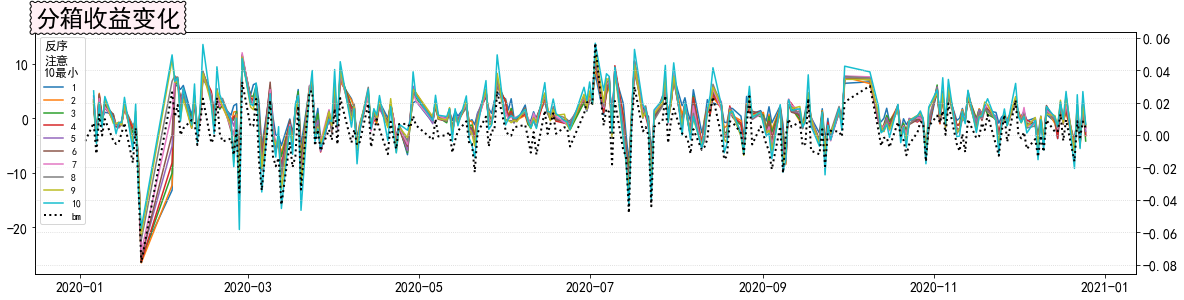

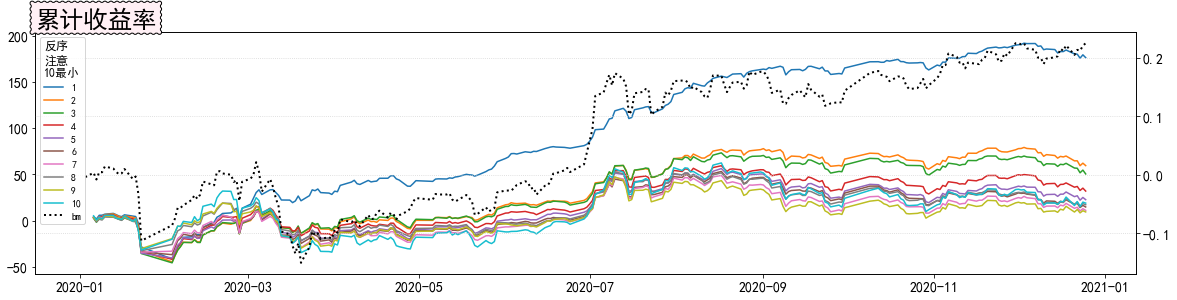

Wall time: 18.7 s


In [ ]:
%%time
from tools.Test_Tools_Simple import FactorTest

# %load_ext autoreload
# %autoreload 1
# %aimport tools.Test_Tools_Simple

fa = pd.DataFrame(amihud).dropna()
fa.columns=['xxx']
test = FactorTest(start=dates.min().strftime('%Y-%m-%d'),end=dates.max().strftime('%Y-%m-%d'),target_field='xxx',blenchmark_name='沪深300', freq="d")
test.process_ind_simple(fa,ret,need_descript=True)
test.plot()


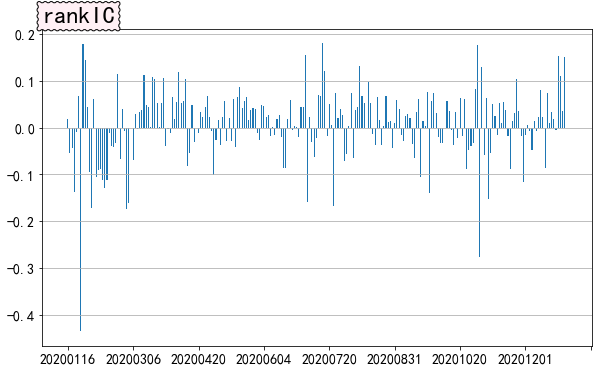

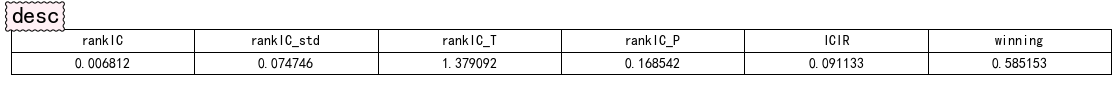

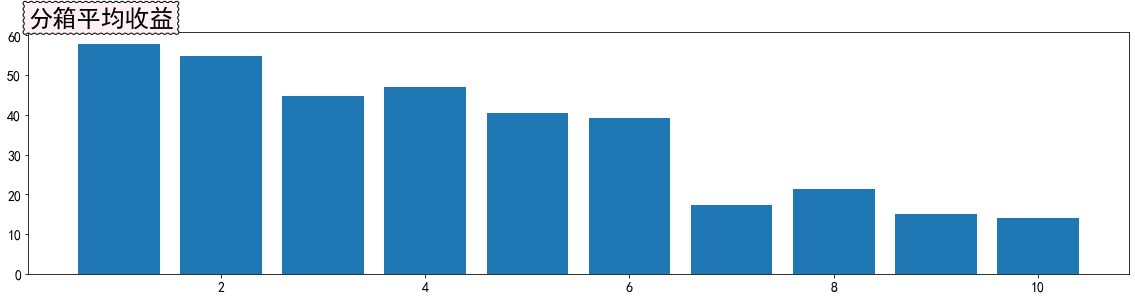

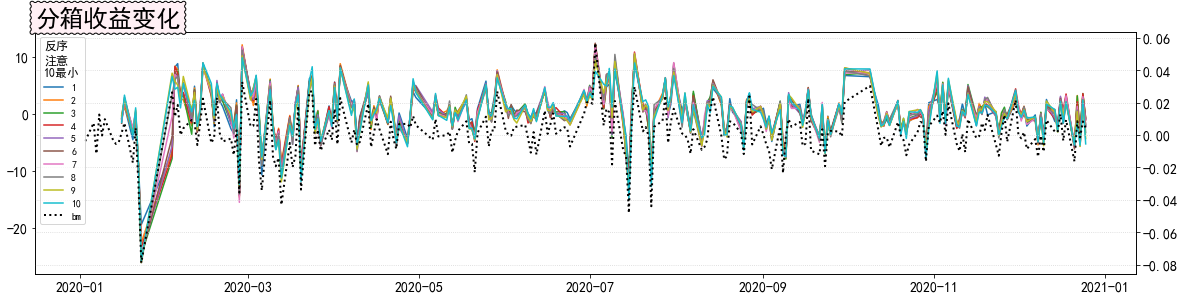

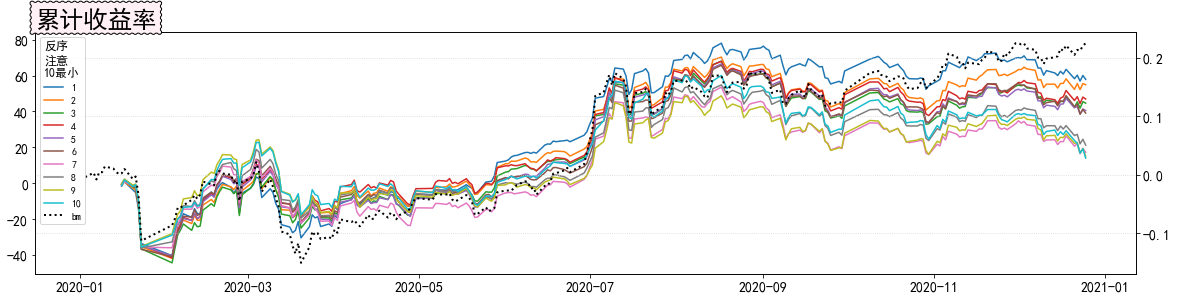

In [119]:
fa = pd.DataFrame(pvc_optimize).dropna()
fa.columns=['xxx']
test = FactorTest(start=dates.min().strftime('%Y-%m-%d'),end=dates.max().strftime('%Y-%m-%d'),target_field='xxx',blenchmark_name='沪深300', freq="d")
test.process_ind_simple(fa,ret,need_descript=True)
test.plot()

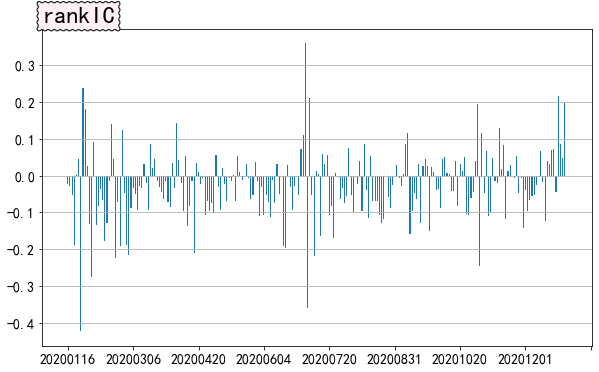

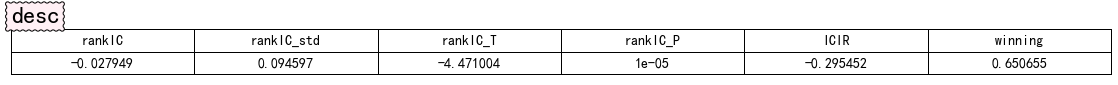

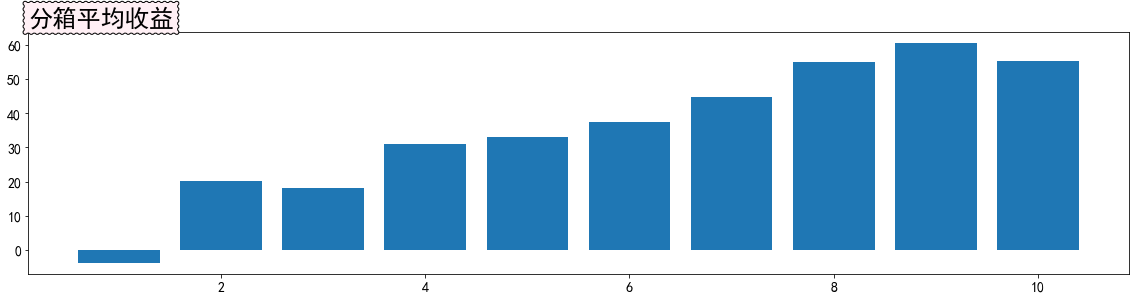

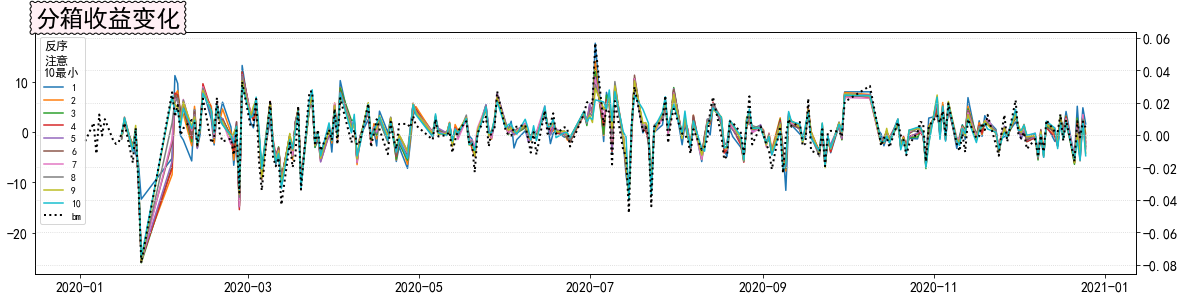

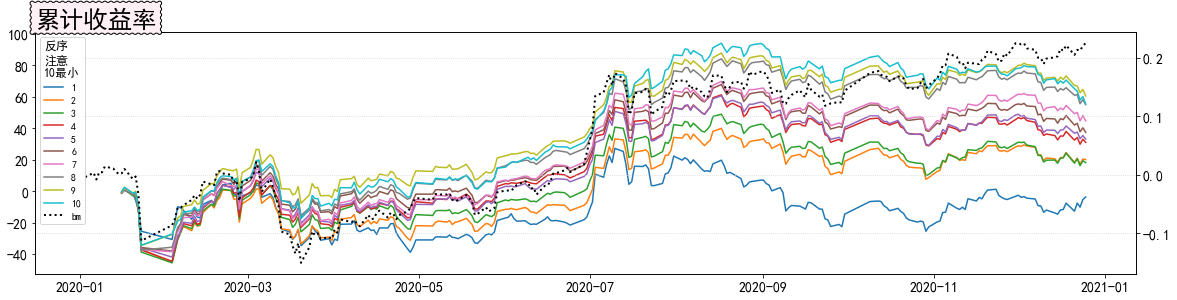

In [28]:
fa = pd.DataFrame(pvc_10).dropna()
fa.columns=['xxx']
test = FactorTest(start=dates.min().strftime('%Y-%m-%d'),end=dates.max().strftime('%Y-%m-%d'),target_field='xxx',blenchmark_name='沪深300', freq="d")
test.process_ind_simple(fa,ret,need_descript=True)
test.plot()


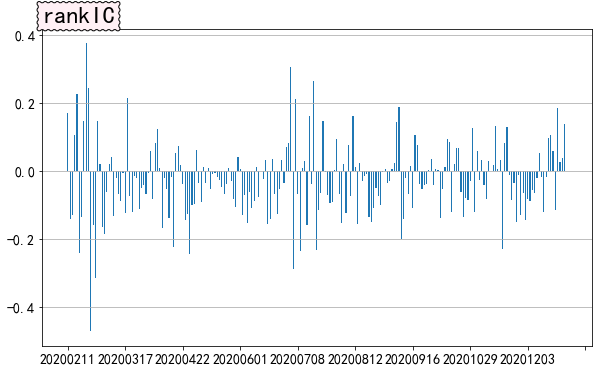

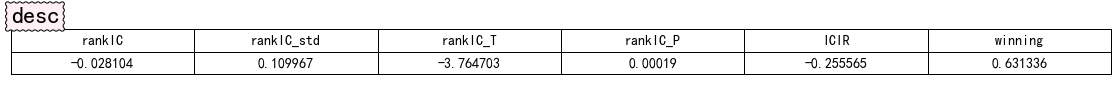

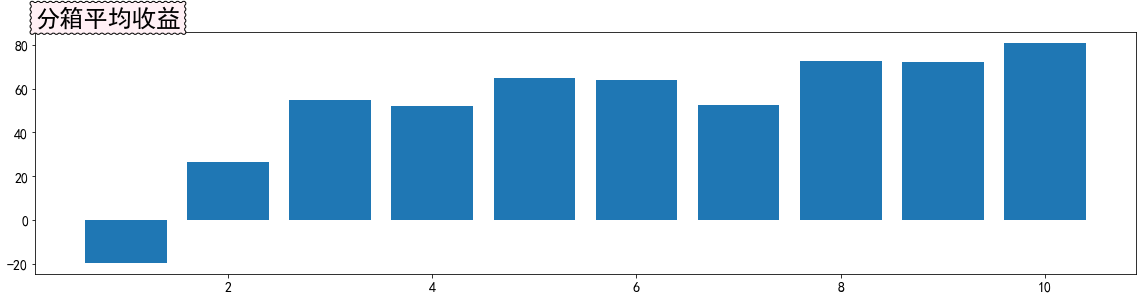

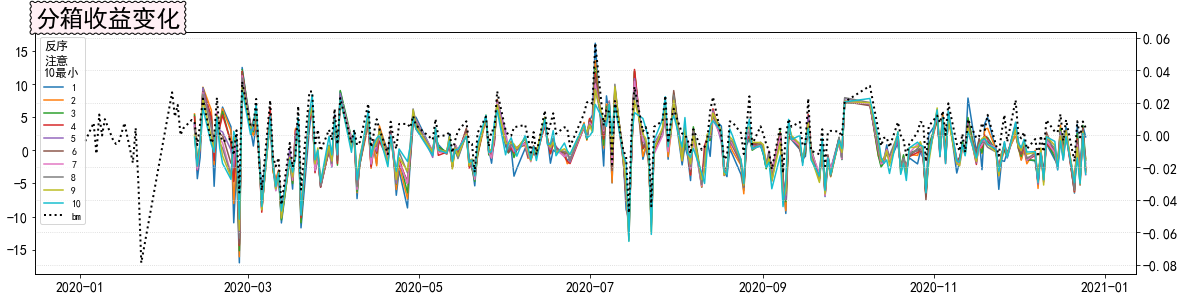

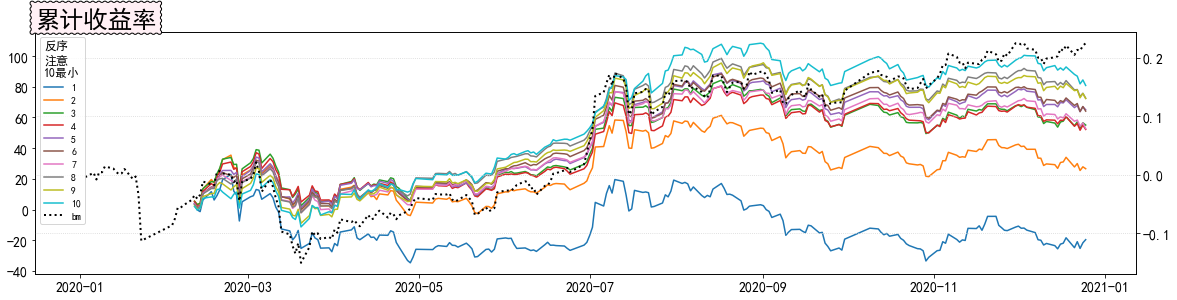

In [29]:
fa = pd.DataFrame(pvc_22).dropna()
fa.columns=['xxx']
test = FactorTest(start=dates.min().strftime('%Y-%m-%d'),end=dates.max().strftime('%Y-%m-%d'),target_field='xxx',blenchmark_name='沪深300', freq="d")
test.process_ind_simple(fa,ret,need_descript=True)
test.plot()
